this use heatmap instead of imshow to generate oncoprint should be adopted from now on.

In [2]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

some notes:
http://www.statisticshowto.com/benjamini-hochberg-procedure/
http://www.biostathandbook.com/multiplecomparisons.html
The Benjamini-Hochberg Procedure is a powerful tool that decreases the false discovery rate.

Adjusting the rate helps to control for the fact that sometimes small p-values (less than 5%) happen by chance, which could lead you to incorrectly reject the true null hypotheses. In other words, the B-H Procedure helps you to avoid Type I errors (false positives).
A p-value of 5% means that there’s only a 5% chance that you would get your observed result if the null hypothesis were true. In other words, if you get a p-value of 5%, it’s highly unlikely that your null hypothesis is not true and should be thrown out. But it’s only a probability–many times, true null hypotheses are thrown out just because of the randomness of results.

A concrete example: Let’s say you have a group of 100 patients who you know are free of a certain disease. Your null hypothesis is that the patients are free of disease and your alternate is that they do have the disease. If you ran 100 statistical tests at the 5% alpha level, roughly 5% of results would report as false positives.

There’s not a lot you can do to avoid this: when you run statistical tests, a fraction will always be false positives. However, running the B-H procedure will decrease the number of false positives.

Benjamini-Hochberg Procedure
Post Hoc Tests > Benjamini-Hochberg Procedure

What is the Benjamini-Hochberg Procedure?
The Benjamini-Hochberg Procedure is a powerful tool that decreases the false discovery rate.

Adjusting the rate helps to control for the fact that sometimes small p-values (less than 5%) happen by chance, which could lead you to incorrectly reject the true null hypotheses. In other words, the B-H Procedure helps you to avoid Type I errors (false positives).


 
A p-value of 5% means that there’s only a 5% chance that you would get your observed result if the null hypothesis were true. In other words, if you get a p-value of 5%, it’s highly unlikely that your null hypothesis is not true and should be thrown out. But it’s only a probability–many times, true null hypotheses are thrown out just because of the randomness of results.

A concrete example: Let’s say you have a group of 100 patients who you know are free of a certain disease. Your null hypothesis is that the patients are free of disease and your alternate is that they do have the disease. If you ran 100 statistical tests at the 5% alpha level, roughly 5% of results would report as false positives.

There’s not a lot you can do to avoid this: when you run statistical tests, a fraction will always be false positives. However, running the B-H procedure will decrease the number of false positives.

How to Run the Benjamini–Hochberg procedure
Put the individual p-values in ascending order.
Assign ranks to the p-values. For example, the smallest has a rank of 1, the second smallest has a rank of 2.
Calculate each individual p-value’s Benjamini-Hochberg critical value, using the formula (i/m)Q, where:
i = the individual p-value’s rank,
m = total number of tests,
Q = the false discovery rate (a percentage, chosen by you).
Compare your original p-values to the critical B-H from Step 3; find the largest p value that is smaller than the critical value.

# 54 samples in total, 20 hiv+, 20 hiv_, 7 hiv+ controls, 7 hiv- controls

In [4]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'

In [5]:
f1 = '{}cellmarkfiletable.txt.full.path'.format(wkdir)
df1 =  pd.read_csv(f1, sep='\t', header=None)
df1.columns = ['patient', 'mark', 'peak_file']
df1.head(2)

,patient,mark,peak_file
0,HTMCP-03-06-02001,H3K4me1,/projects/chipseq/macs/A84610/75nt/hg19a/bwa-0...
1,HTMCP-03-06-02001,H3K4me3,/projects/chipseq/macs/A84611/75nt/hg19a/bwa-0...


In [390]:
# for mark in [] 
# mark = 'H3K27ac'
mark = 'H3K4me3'

In [391]:
dfm = pd.DataFrame()
for ix, f in df1.iterrows():
    fl = f.peak_file
    if mark in fl:
        dftmp = pd.read_csv(fl, sep='\t', header=None, low_memory=False)
        dftmp.columns = ['chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 
                         'unknown', 'fold_change', '-log10pvalue', '-log10qvalue', 
                         'summit_position' ]        
        if dfm.empty:
            dfm = dftmp
        else:
            dfm = pd.concat([dfm, dftmp])

In [392]:
dfm.head()

,chr,start,end,peak_id,qvalue_int_score,unknown,fold_change,-log10pvalue,-log10qvalue,summit_position
0,1,27808,29354,A84611_H3K4me3_peak_1,220,.,6.81288,25.23071,22.09507,1409
1,1,29454,30203,A84611_H3K4me3_peak_2,122,.,5.79157,14.74403,12.28112,273
2,1,96319,96851,A84611_H3K4me3_peak_3,62,.,4.99833,8.40929,6.27830,273
3,1,97136,97459,A84611_H3K4me3_peak_4,54,.,4.66511,7.53040,5.44748,163
4,1,236155,236322,A84611_H3K4me3_peak_5,53,.,3.61891,7.37715,5.31782,59


In [1]:
dfm['-log10qvalue'].min()

NameError: name 'dfm' is not defined

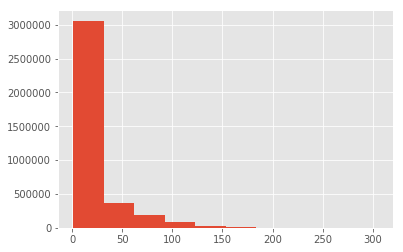

In [393]:
dfm['-log10qvalue'].hist()

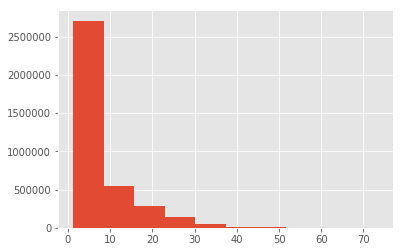

In [394]:
dfm['fold_change'].hist()

In [397]:
dfm.shape

(717226, 10)

In [396]:
# need to pick significant peaks using combinations of fold enrichment and -log10qvalue
# the bigger the better for both, but aware extreme values
dfm = dfm[(dfm.fold_change >5)&(dfm.fold_change<50)&(dfm['-log10qvalue']>30)&(dfm['-log10qvalue']<200)]

In [399]:
of = '{0}{1}_merged_peaks.txt'.format(wkdir, mark)
dfm.to_csv(of, index=False)

In [400]:
%%bash
# figure out the regions with peaks
# mark='H3K27ac'
mark='H3K4me3'
cd /projects/da_workspace/DA-167_Cervical_epi_clustering
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
awk -F "," '{print $1"\t"$2"\t"$3}' $mark"_merged_peaks.txt" |grep -v "^GL"|grep -v "^MT"|grep -v "^chr"|sed 's/X/23/g'|sed 's/Y/24/g'|sort -k1n -k2n -k3n > $mark/$mark"_coor_with_peaks.txt"
cd $mark
$bedtools merge -i $mark"_coor_with_peaks.txt" > $mark"_coor_with_peaks_merged.txt"

In [401]:
f2 = '{0}/{1}/{2}_coor_with_peaks_merged.txt'.format(wkdir, mark, mark)
df2 = pd.read_csv(f2, header=None, sep='\t')
df2.columns = ['chr', 'start', 'end']
df2['seg_len'] = df2.end - df2.start
df2.head(2)

,chr,start,end,seg_len
0,1,27470,31232,3762
1,1,90601,91399,798


In [402]:
df2.seg_len.describe()

count    55519.000000
mean      3073.324664
std       2874.215894
min        189.000000
25%       1327.000000
50%       2144.000000
75%       3872.000000
max      64340.000000
Name: seg_len, dtype: float64

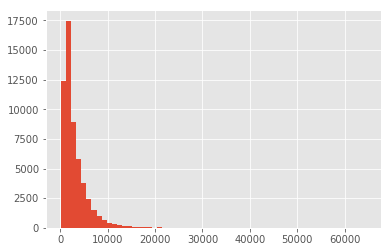

In [403]:
# segment length distribution
df2.seg_len.hist(bins=60)

In [404]:
# break large segment into 1 kb segment, need to remove segments < 200bp
segments = []
for ix, row in df2.iterrows():
    chr = row.chr
    start = row.start
    end = row.end
    length = row.seg_len
    if row.seg_len >2000: 
#         print('>2000', chr, start, end, length)
        for i in range(int(length/1000)):
#             print(i, start+1000*i+1, start+1000*(i+1))
            segments.append([chr, start+1000*i+1, start+1000*(i+1)])
#         print(chr, start+1000*(i+1)+1, end)
        if start+1000*(i+1)+1 < end:
            segments.append([chr, start+1000*(i+1)+1, end])
    else:
#         print("<2000", chr, start, end, length)
        segments.append([chr, start, end])



In [405]:
len(segments)

179417

In [406]:
dfseg = pd.DataFrame(segments)
dfseg.to_csv('{0}/{1}/{1}_coor_with_peaks_merged_1kb_split.txt'.format(wkdir, mark), sep='\t', index=False, header=False)

In [407]:
%%bash
#sort peak files and intersect with merged/split peak regions, required 50% overlap
# mark='H3K27ac'
mark='H3K4me3'

bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd /projects/da_workspace/DA-167_Cervical_epi_clustering/
while read i;do grep $i cellmarkfiletable.txt.full.path>$mark/$i.peak.files.txt;done < marks.txt
cd $mark
while read a b c;do cat $c|grep -v "^GL"|grep -v "^MT"|grep -v "^chr"|sed 's/X/23/g'|sed 's/Y/24/g'|sort -k1n -k2n -k3n > $a.$b.sorted;done < $mark.peak.files.txt

awk '$3-$2>100' $mark"_coor_with_peaks_merged_1kb_split.txt">  $mark"_coor_with_peaks_merged_1kb_split.rm.txt"
for f in HTMCP*.$mark.sorted; do $bedtools intersect -f 0.5 -a $mark"_coor_with_peaks_merged_1kb_split.rm.txt" -b $f -wa -wb>$f.intersected;done

In [408]:
f3 = '/projects/da_workspace/DA-167_Cervical_epi_clustering/{0}/{0}.sorted.intersected.files'.format(mark)

In [430]:
f3

'/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3/H3K4me3.sorted.intersected.files'

In [431]:
df3 = pd.read_csv(f3, header=None)
df3.columns = ['files']
df3.head(2)

,files
0,HTMCP-03-06-02001.H3K4me3.sorted.intersected
1,HTMCP-03-06-02006.H3K4me3.sorted.intersected


In [432]:
df3.shape


(35, 1)

In [433]:
subdir = '{0}{1}/'.format(wkdir, mark)
dfmg = pd.DataFrame()
for ix, row in df3.iterrows():
    patient = row.files.split('.')[0]
    f = ''.join([subdir, row.files])
    dftmp = pd.read_csv(f, sep='\t', header=None, usecols=[0,1,2])
    dftmp[patient] = 1
    dftmp.set_index([0,1,2], inplace=True)
    if dfmg.empty:
        dfmg = dftmp
    else:
        dfmg = pd.merge(dfmg, dftmp, left_index=True, right_index=True, how='outer')
#     dftmp.head()
#     break

In [434]:
dfmg.fillna(0,inplace=True)

In [469]:
dfmg.shape

(226843, 37)

In [470]:
dfmg.head(2)

HTMCP-03-06-02007  HTMCP-03-06-02182  HTMCP-03-06-02006  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02040  HTMCP-03-06-02075  HTMCP-03-06-02266  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02180  HTMCP-03-06-02203  HTMCP-03-06-02210  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02012   ...     HTMCP-03-06-02020  \
0 1     2                          ...                         
1 25940 26169                0.0   ...                   0.0   
  26341 26650                0.0   ...                   0.0   

               HTMCP-03-06-02320  HTMCP-03-06-02054  HTMCP-03-06-02001  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02260  HTMCP-03-06-02109  HTMCP-03-06-02128  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02076  neg_sum  pos_sum  
0 1     2                                           
1 25940 26169                0.0      0.0      1.0  
  26341 26650                0.0      0.0      1.0  

[2 rows x 37 columns]

In [437]:
# remove regions with peak in all samples

dfmg = dfmg[dfmg.sum(axis=1) != 35]
dfmg.shape

(226843, 35)

In [482]:
wkdir

'/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3_promoter/'

In [438]:
f = '{}clinic_covariate.csv'.format(wkdir)
print(f)
dfcov = pd.read_csv(f, index_col='patient', sep='\t')
dfcov.head(2)
dfcov.shape

/projects/da_workspace/DA-167_Cervical_epi_clustering/clinic_covariate.csv


,HIV_status,Putative_histology,clinic_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,tobacco_smoking_history_indicator,ecog_score,nadir_cd4_counts,cd4_counts_at_diagnosis.1,hiv_rna_load_at_diagnosis.1,histologic_diagnosis,haart_therapy_prior_to_dx,haart_therapy_at_dx,keratinization_squamous_cell,days_to_hiv_diagnosis
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02007,Negative,Adeno,Adenosquamous,Negative,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,...,1.0,1,unknown,unknown,unknown,Squamous Cell Carcinoma; Non-Keratinizing,unknown,unknown,Non-keratinizing squamous cell carcinoma,unknown
HTMCP-03-06-02026,Negative,Adeno,Adeno,Negative,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,...,1.0,1,unknown,unknown,unknown,Squamous Cell Carcinoma; Non-Keratinizing,unknown,unknown,Non-keratinizing squamous cell carcinoma,unknown


(35, 54)

In [439]:
category_lst = ['HIV_status',  'clinic_histology',
       'HPV_status', 'Remodeller', 'Reader', 'Writer',
       'Eraser', 'SWI/SNF remodeling complex', 'SWI/SNF family',
       'ISWI remdelling complexes', 'SEC (Super Elongation) Complex',
       'INO80/SWR remodelling complexes', 'Testis-specific chromatin protein',
       'chromatin remodelling', 'EP300/CBP HAT complexes', 'Polycomb complex',
       'REST corepressor', 'ISWI chromatin remdelling', 'HAT complexes',
       'NuRD complex', 'compass complex', 'HDAC complex',
       'GNAT family HAT complexes', 'MYST family HAT complexes',
       'RNF20/40 complex', 'SWI/SNF  remodeling complex',
       'TFIID basal transcription factor complex or PCAF histone acetylase complex', 
        'tumor_grade', 'clinical_stage', 'history_hormonal_contraceptives_use', 
        'haart_therapy_prior_to_dx', 'haart_therapy_at_dx']
numeric_lst = ['age_at_diagnosis',  'cd4_counts_at_diagnosis',
               'hiv_rna_load_at_diagnosis', 'weight_kg_at_diagnosis', 
       'live_birth_pregnancy_count', 'total_pregnancy_count',
       'pregnancies_count_miscarriage', 'pregnancies_count_induced_abortion',
       'karnofsky_score', 'tobacco_smoking_history_indicator', 'ecog_score',
       'nadir_cd4_counts',   'days_to_hiv_diagnosis']

# dfcov = dfcov[lst]

In [440]:
# dfcov = dfcov[numeric_lst]
dfcov = dfcov[category_lst].fillna('unknown')
dfcov = dfcov.T

In [441]:
dfcov.shape

(32, 35)

In [442]:
dfcov.head(2)

patient,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02063,HTMCP-03-06-02214,HTMCP-03-06-02042,HTMCP-03-06-02332,HTMCP-03-06-02185,HTMCP-03-06-02012,HTMCP-03-06-02196,HTMCP-03-06-02203,...,HTMCP-03-06-02097,HTMCP-03-06-02268,HTMCP-03-06-02202,HTMCP-03-06-02148,HTMCP-03-06-02103,HTMCP-03-06-02089,HTMCP-03-06-02205,HTMCP-03-06-02179,HTMCP-03-06-02109,HTMCP-03-06-02076
HIV_status,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
clinic_histology,Adenosquamous,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adenosquamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous


In [443]:
def add_categrory_covariate(dfcov, col_den_labels):
    dfcov = dfcov[col_den_labels]
    nrows = dfcov.shape[0]
    
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in dfcov.iterrows():
        categories = sorted(row.unique())
#         print(categories)
        clrs = [ "purple", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
         # make map dictionary
        map_dict = {k:v for v, k in  enumerate(categories)} 
        clrs = clrs[:len(map_dict)]    
        types = len(map_dict)
        cmap = colors.ListedColormap(clrs)
        dfa = pd.DataFrame(index=[ix], columns=dfcov.columns)
        dfa.loc[ix,:] = dfcov.loc[ix,].map(map_dict).astype(float)

        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False) #cbar_ax=ax1,
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)

        k = 0
        for key, clr in zip(map_dict.keys(), clrs):

            rect = patches.Rectangle((0,k/types), 0.2, 1/types, 
                                     linewidth=0.001,
                                     edgecolor=clr,
                                     facecolor=clr)

            _ = ax0.text(0.25, k/types+0.05, 
                         key, 
                         ha='left', 
                         va='center', 
                         fontsize=6)
            _ = ax0.add_patch(rect)
            k+=1
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')
        grid_num+=2
    plt.show()


In [444]:
def add_numeric_covariate(dfcov):
    dfcov = dfcov[col_den_labels].fillna(0.0)
    nrows = dfcov.shape[0]
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in dfcov.iterrows():
        dfa = pd.DataFrame(index=[ix], columns=dfcov.columns)
        dfa.loc[ix,:] = dfcov.loc[ix,].astype(float)
        dfa = dfa.astype(float)
        # add cbar ax
        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)   
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')


        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap = sns.light_palette('red', as_cmap=True),
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=True,
                        cbar_ax=ax0)
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        grid_num+=2
    plt.show()
    return dfa


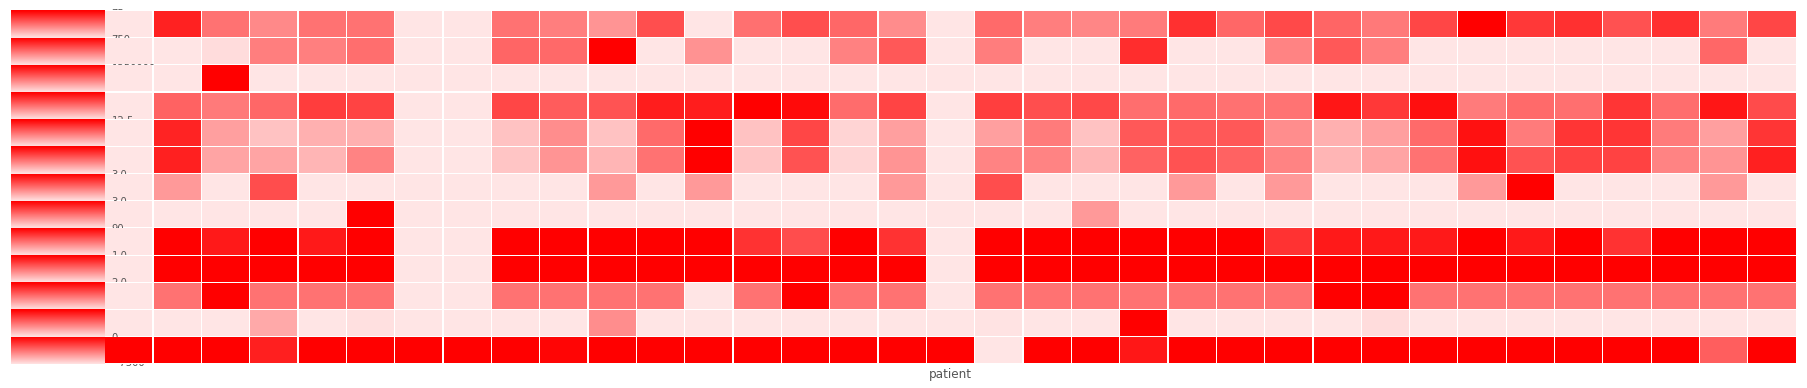

In [596]:
aa = add_numeric_covariate(dfcov)

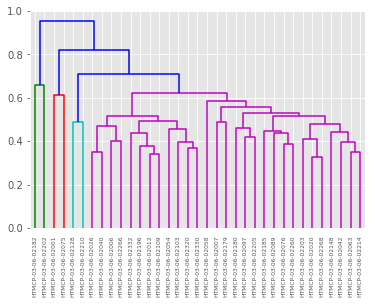

In [445]:
# add column dendrogram
# pdist(Y,'jaccard') returns jaccard distance, which is 1-jaccard similarity value, pairwise distance, so order in each vector matters, 
# but paired u[i], v[i] change order does not matter. important to note, it ignores pairs with both values are 0.
# pdist([[1, 2, 2], [2,2,1]],'jaccard') = 0.666 not 0
# pdist([0,1,1], [0,0,1]) = 0.5

matrix = (dfmg).T.values
dist='jaccard' # this is jaccard distance 1-jaccard value
link='complete'    
Z = linkage(pdist(matrix, dist), link)
col_den = dendrogram(Z, leaf_rotation=90.,
                     labels = dfmg.columns,
                     leaf_font_size=6.,
                     show_contracted=True)#, 
#                      no_labels=True)
col_den_labels = col_den['ivl']

In [480]:
#use this to make clustered heatmap and use add_covariate to make separate tracksS
def plot_cluster_heatmap(dfm, dfcov):  
    fig = plt.figure(figsize=(16, 20), facecolor='white')
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,15], height_ratios=[10, 2, 3], 
                           wspace=0.0, # horizontal space
                           hspace=0.3  # vertical space
                          )    
    # plot covariate track: to develop
#     add_covariate(df_cov, map_dict, clrs)
    
     # add column dendrogram
    gs3 = gs[3]
    ax3 = plt.subplot(gs3, facecolor='white')
    ax3.set_title("")
    
    matrix = (dfm).T.values
    dist='jaccard' # this is jaccard distance 1-jaccard value
    link='complete'    
    Z = linkage(pdist(matrix, dist), link)
    col_den = dendrogram(Z, leaf_rotation=90.,
                         labels = dfm.columns,
                         leaf_font_size=12.,
                         show_contracted=True,
                         ax=ax3)#, 
#                          no_labels=False)
    col_den_labels = col_den['ivl']
    
      
#     add in heatmap
    gs1 = gs[1]
    nrows = dfcov.shape[0]
    gssubs = gridspec.GridSpecFromSubplotSpec(nrows, 1,  
                                    height_ratios=[1]*nrows,
                                    subplot_spec=gs[1])
    grid_num = 0
    dfcov = dfcov[col_den_labels] 
    for ix, row in dfcov.iterrows():
        categories = sorted(row.unique())
        print('heatmap categories order', categories)
        clrs = [ "purple", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
         # make map dictionary
        map_dict = {k:v for v, k in  enumerate(categories)} 
        clrs = clrs[:len(map_dict)]    
        types = len(map_dict)
        cmap = colors.ListedColormap(clrs)
        dfa = pd.DataFrame(index=[ix], columns=dfcov.columns)
        dfa.loc[ix,:] = dfcov.loc[ix,].map(map_dict).astype(float)

        # add covariate track legend
        gs11 = gssubs[grid_num]
        ax11 = plt.subplot(gs11, facecolor='white')
        _ = ax11.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax11, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False)#,
#                         cbar_ax=ax00)
        _ = ax11.tick_params(axis='y', which='major', labelsize=5)
        _ = ax11.set_yticklabels(ax11.yaxis.get_majorticklabels(), rotation=0)
        _ = ax11.yaxis.tick_right()
        _ = ax11.set_title("")
        _ = ax11.set_xlabel('')
        _ = ax11.set_ylabel(ix, rotation=0, fontsize=10)
        ax11.get_yaxis().set_label_coords(-0.15,0.5)
#         ax11.yaxis.set_label_position("right")
        grid_num+=1



    # plot all legend, need to work out
    gs5 = gs[5]
    ax5 =  plt.subplot(gs5, frameon=True,facecolor='white')
    num_legends = len(covariate_dict)
    column = 0
    for covariate in covariate_dict:
        groups = covariate_dict[covariate]
        clrs = [ "purple", "#E69F00","#009E73","#56B4E9","#377EB8",
                "#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
        # make map dictionary
        map_dict = {k:v for v, k in  enumerate(groups)} 
        clrs = clrs[:len(map_dict)]    
        clrmap_dict = {k:v for k, v in zip(map_dict.keys(), clrs)}
        add_patches(covariate, ax5, clrmap_dict.keys(), column, clrmap_dict, num_legends)
        column+=1


    
#     assert row_den_labels == df_hm.index.tolist()
#     assert col_den_labels == df_hm.columns.tolist()

    of = '{0}/{1}_heatmap.png'.format(wkdir, mark)
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return col_den

In [479]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3_promoter/'

In [478]:
mark

'H3K4me3'

In [447]:
patients = dfcov.sort_values('HIV_status',axis=1).columns
dfmg = dfmg[patients]
dfmg['neg_sum'] = dfmg.iloc[:,:17].sum(axis=1)
dfmg['pos_sum'] = dfmg.iloc[:,17:35].sum(axis=1)

In [459]:
dfmg_s = dfmg[(np.abs(dfmg['neg_sum'] - dfmg['pos_sum']) > 7)].drop(['neg_sum', 'pos_sum'], axis=1)
dfmg_s.shape

(696, 35)

In [970]:
# of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/H3K27ac_hiv_differential_peaks.txt'
# dfmg_s.reset_index().to_csv(of, index=False, sep='\t')

In [449]:
dfcov.head()

patient,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02063,HTMCP-03-06-02214,HTMCP-03-06-02042,HTMCP-03-06-02332,HTMCP-03-06-02185,HTMCP-03-06-02012,HTMCP-03-06-02196,HTMCP-03-06-02203,...,HTMCP-03-06-02097,HTMCP-03-06-02268,HTMCP-03-06-02202,HTMCP-03-06-02148,HTMCP-03-06-02103,HTMCP-03-06-02089,HTMCP-03-06-02205,HTMCP-03-06-02179,HTMCP-03-06-02109,HTMCP-03-06-02076
HIV_status,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
clinic_histology,Adenosquamous,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adenosquamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Squamous
HPV_status,Negative,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
Remodeller,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Mutated,Wild Type,Wild Type,...,Wild Type,Wild Type,Wild Type,Mutated,Mutated,Wild Type,Wild Type,Wild Type,Mutated,Wild Type
Reader,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,...,Wild Type,Wild Type,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,Wild Type,Wild Type


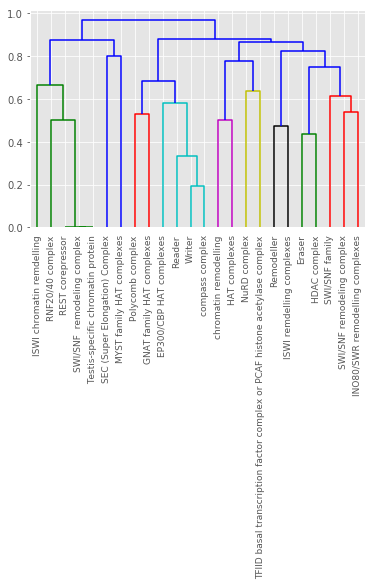

In [460]:
# figure out order of complex
dftmp = dfcov.apply(lambda x: x.map({'Mutated':1, 'Wild Type':0})).dropna()
matrix = dftmp
dist='jaccard' # this is jaccard distance 1-jaccard value
link='complete'    
Z = linkage(pdist(matrix, dist), link)
col_den = dendrogram(Z, leaf_rotation=90.,
                     labels = dftmp.T.columns,
                     leaf_font_size=9.,
                     show_contracted=True)#, 
#                          no_labels=False)
col_den_labels = col_den['ivl']
# col_den_labels
lst = ['HIV_status', 'clinic_histology', 'HPV_status'] + col_den_labels + ['tumor_grade', 'clinical_stage', 'history_hormonal_contraceptives_use',
       'haart_therapy_prior_to_dx', 'haart_therapy_at_dx']
dfcov = dfcov.reindex(lst)

In [461]:
def get_legend_categories(dfcov):
    a = []
    covariate_dict = {}
    for ix, row in pd.DataFrame(dfcov.apply(lambda x: sorted(x.unique().tolist()), axis=1)).iterrows():
    #     print(ix, row[0])
        item = row[0]
        if item not in a:
            a.append(item)
            covariate_dict[ix] = item
    return covariate_dict

In [462]:
covariate_dict = get_legend_categories(dfcov)

In [463]:
def add_patches(covariate, ax, features, column, clrmap_dict, num_legends):
    k = 0
    _ = ax.text(0.0+column*(1/(num_legends + .2)), .9, 
                 covariate, 
                 ha='left', 
                 va='center', 
                 fontsize=12)
#     print(sorted(features))
    for feature in sorted(features):
#         print(feature)
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*(1/(num_legends + .2)), .8-k*0.15), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*(1/(num_legends + .2)), .8-k*0.15+.03, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')


In [473]:
dfmg.head(2)

HTMCP-03-06-02007  HTMCP-03-06-02182  HTMCP-03-06-02006  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02040  HTMCP-03-06-02075  HTMCP-03-06-02266  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02180  HTMCP-03-06-02203  HTMCP-03-06-02210  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02012   ...     HTMCP-03-06-02020  \
0 1     2                          ...                         
1 25940 26169                0.0   ...                   0.0   
  26341 26650                0.0   ...                   0.0   

               HTMCP-03-06-02320  HTMCP-03-06-02054  HTMCP-03-06-02001  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02260  HTMCP-03-06-02109  HTMCP-03-06-02128  \
0 1     2                                                                
1 25940 26169                0.0                0.0                0.0   
  26341 26650                0.0                0.0                0.0   

               HTMCP-03-06-02076  neg_sum  pos_sum  
0 1     2                                           
1 25940 26169                0.0      0.0      1.0  
  26341 26650                0.0      0.0      1.0  

[2 rows x 37 columns]

heatmap categories order ['Negative', 'Positive']
heatmap categories order ['Adeno', 'Adenosquamous', 'Squamous']
heatmap categories order ['Negative', 'Positive']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated', 'Wild Type']
heatmap categories order ['Mutated',

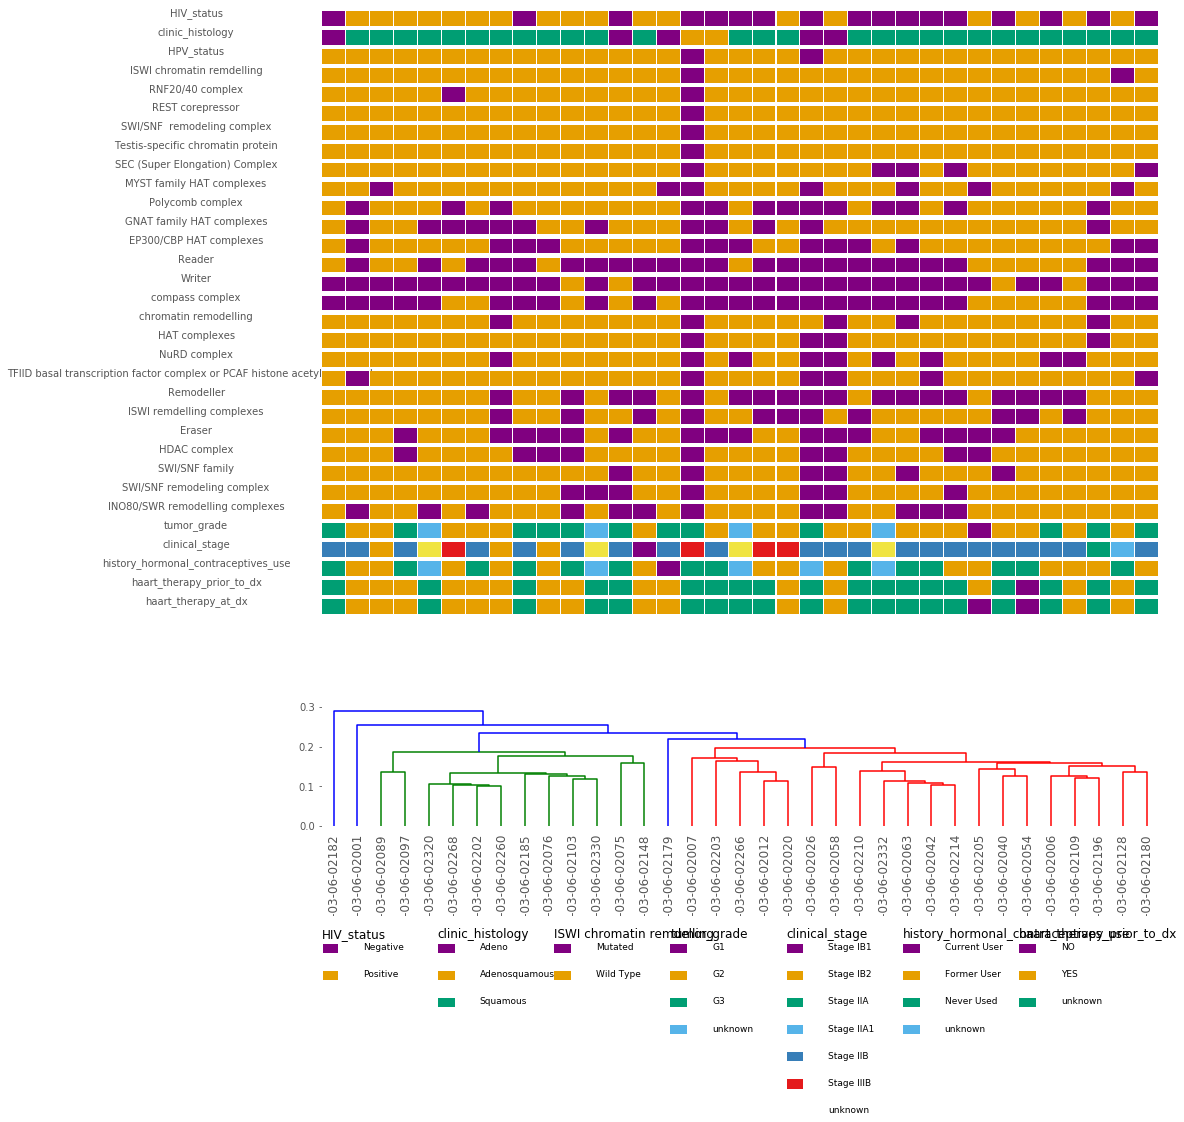

In [481]:
col_den = plot_cluster_heatmap(dfmg, dfcov)

In [474]:
f = '/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3_promoter/H3K4me3.promoter.txt'
dfmg = pd.read_csv(f, index_col='ix')
dfmg.head()

,HTMCP-03-06-02001,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02040,HTMCP-03-06-02042,HTMCP-03-06-02054,HTMCP-03-06-02058,...,HTMCP-03-06-02203,HTMCP-03-06-02205,HTMCP-03-06-02210,HTMCP-03-06-02214,HTMCP-03-06-02260,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
ix,,,,,,,,,,,,,,,,,,,,,
10_100026007_100030006,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10_100172941_100176940,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10_100204684_100208683,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10_100993619_100997618,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10_101086857_101090856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [466]:
of = '{0}/{1}/differentiating_regions.txt'.format(wkdir, mark)
dfmg_s.reset_index()[[0,1,2]].to_csv(of, index=False, sep='\t', header=False)

In [467]:
%%bash
mark='H3K4me3'
cd /projects/da_workspace/DA-167_Cervical_epi_clustering/$mark
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
$bedtools intersect -a differentiating_regions.txt -b /home/szong/projects/resource/ens69/hg19v69_genes.TSS_2000.pc.bed -f 0.1 -wa -wb >differentiating_regions.txt.intersect_tss 
while read a b c d e f g;do echo -ne $a"\t"$b"\t"$c"\t";grep $g /home/szong/projects/resource/ens69/gene_info_ens69_nina.txt;done < differentiating_regions.txt.intersect_tss > differentiating_regions.txt.intersect_tss.genes

In [362]:
(dfmg_s.reset_index())[[0,1,2]]

,0,1,2
0,1,1358107,1359106
1,1,6360563,6361562
2,1,17515800,17516799
3,1,17516800,17517799
4,1,17607281,17608280
5,1,17608281,17609280
6,1,27327213,27328212
7,1,27981709,27983585
8,1,28448211,28449210
9,1,32805281,32806209


In [ ]:
qvalues = np.array([0])

for ix, f in df1.iterrows():
    fl = f.peak_file
    
    if 'H3K4me3' in fl:
        dftmp = pd.read_csv(fl, sep='\t', header=None)
        dftmp.columns = ['chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 'unknown', 'fold_change', '-log10pvalue', '-log10qvalue', 'summit_position' ]
    #     df.head(2)
#         print(dftmp.shape)
        arr = dftmp['-log10qvalue'].values
    
        qvalues = np.append(qvalues, arr)

In [39]:
qvalues.shape

(3695470,)

In [944]:
pdist([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

array([1.73205081])

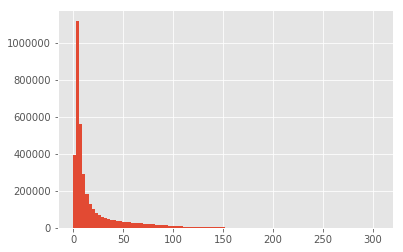

In [40]:
_ = plt.hist(qvalues, bins=100)

In [7]:
# filter signals based on qvalues, threshold?
f = '/projects/chipseq/macs/A84610/75nt/hg19a/bwa-0.5.7/MACS_2.1.1.20160309/A84610_H3K4me1_peaks.broadPeak'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 'unknown', 'fold_change', '-log10pvalue', '-log10qvalue' ]
df.head(2)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,start,end,peak_id,qvalue_int_score,unknown,fold_change,-log10pvalue,-log10qvalue
0,1,13476,14417,A84610_H3K4me1_peak_1,87,.,2.98088,10.82448,8.78205
1,1,26077,28545,A84610_H3K4me1_peak_2,80,.,3.77017,9.99989,8.03116


In [8]:
df.describe()


,start,end,qvalue_int_score,fold_change,-log10pvalue,-log10qvalue
count,2.162410e+05,2.162410e+05,216241.000000,216241.000000,216241.000000,216241.000000
mean,8.041636e+07,8.041778e+07,32.291402,2.898499,4.726002,3.278885
std,5.561081e+07,5.561082e+07,17.440639,0.600229,1.938275,1.744036
min,7.930000e+02,1.681000e+03,10.000000,1.539210,2.175560,1.003790
25%,3.560896e+07,3.560980e+07,19.000000,2.440730,3.232680,1.933940
50%,7.100849e+07,7.101022e+07,27.000000,2.761590,4.189860,2.791230
75%,1.165717e+08,1.165767e+08,42.000000,3.246260,5.756940,4.204910
max,2.492381e+08,2.492382e+08,188.000000,6.700070,21.976260,18.801840


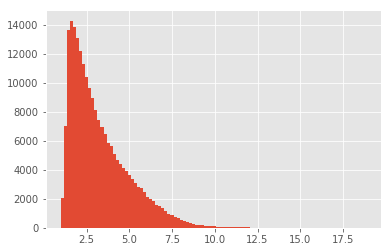

In [12]:
df['-log10qvalue'].hist(bins=100)

If you look at the "GeneAnno" plot (ie genomic region annotations), "genic enhancers" occur more frequently in gene bodies, and occur in exons, while "enhancers" (state 7) occur less frequently in gene bodies and almost never in exons. Both seem to occur in introns with equal frequency. If you dig into the raw data, you can also see that the "genic enhancers" occur at TSS about twice as frequently. Also, the "genic enhancers" occur about 26 times less frequently genome-wide.

http://egg2.wustl.edu/roadmap/data/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final/annotationEnrichment_RoadmapEp_coreMarks_15State.png

http://egg2.wustl.edu/roadmap/data/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final/E003_15_coreMarks_geneAnno_overlap.txt

It's important to note that these are probabilistic categories based solely on the histone marks -- there are probably some promoters/TSS mixed in with the regions annotated as genic enhancers. Conversely, many of the genic enhancers may be located intergenically. Lastly, there is no guarantee that any of the regions annotated as enhancers actually function as such. If they do function as enhancers, then they must, by necessity, be brought into proximity to promoters via enhancer-promoter looping. This mechanism functions regardless of whether they are genic or intergenic.